# Large deformations for points.

In [5]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi

## Invertable mappings have nonzero determinant of Jacobian

## The failure of smooth splines
Regardless of how smooth a Green's kernel is chosen to be, the simple transformation defined by one landmark point at $x_0$, $x\mapsto x + a K(x - x_0)$, will become not invertable for some value of $a \in \mathbb{R}^d$ (for $d=1,2$ or 3 as appropriate).

To see this, consider the 1d problem with a Gaussian kernel, and look at the determinant of Jacobian of the mapping, which is just the derivative in this case.

\begin{align*}
\frac{d}{dx} x + a \exp( -|x - x_0|^2/2\sigma^2) &= 1 - a\sigma^2 (x - x_0) \exp( -|x - x_0|^2/2\sigma^2)
\end{align*}

Consider the point $x = x_0 + 1$.  The expression becomes $1 - a\sigma^2 \exp(-1/2\sigma^2)$.  This is zero for $a = \frac{1}{\sigma^2 \exp(-1/2\sigma^2)}$, and negative for any larger $a$.

Regardless of how smooth $K$ is, we will run into this problem for large deformations.

Notice however that for small $a$, the determinant of Jacobian becomes arbitrarily close to 1.  Small enough deformations are always invertable with smooth kernels.

<IPython.core.display.Javascript object>


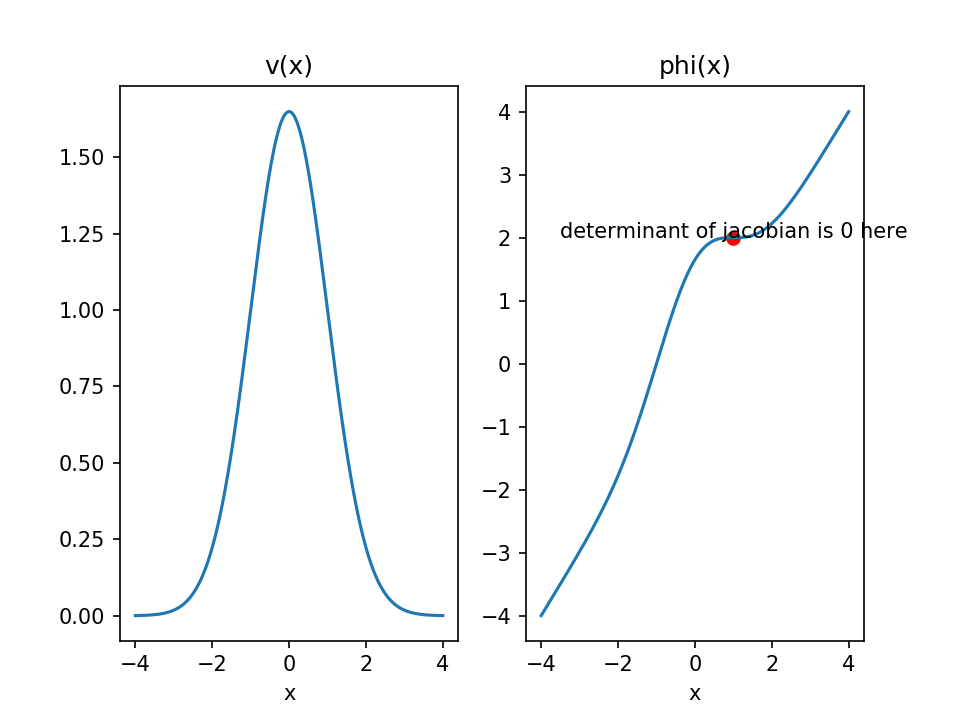

Text(1,2,'determinant of jacobian is 0 here')

In [22]:
# example
sigma = 1.0
x = np.linspace(-4,4,500)
x0 = 0.0

a = 1.0/(sigma**2 * np.exp(-1.0/2.0/sigma**2))
v = a * np.exp( -(x - x0)**2/2.0/sigma**2 )

f,ax = plt.subplots(1,2)
ax[0].plot(x,v)
ax[0].set_xlabel('x')
ax[0].set_title('v(x)')
ax[1].plot(x,x+v)
ax[1].set_xlabel('x')
ax[1].set_title('phi(x)')
ax[1].scatter(1,1 + a * np.exp(-(1)**2/2.0/sigma**2),color='r')
ax[1].text(1,1 + a * np.exp(-(1)**2/2.0/sigma**2), 'determinant of jacobian is 0 here', horizontalalignment='center')

## Combining small deformations under composition works
Because small deformations will be 